# AuxTel batoid input different amounts of  Zk11, fit with WEP and CWFS...

In [1]:
import numpy as np # standard package for doing calculations
import matplotlib.pyplot as plt # standard package for plotting

import batoid
import galsim

import sys
sys.path.append('/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/wfsim/')
import wfsim

We want to simulate specific Zernike perturbations. We use phase screen. 

Wrap that simulation as a function:

In [18]:
def simulate_auxtel_zernikes(seed = 0, z_in = [0,0,0,0,200e-9,0,0,0,0,0,0,0],
                            fname = "auxTel_batoid_zk"):

    auxtel = batoid.Optic.fromYaml("AuxTel.yaml")
    bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')
    rng = np.random.default_rng(seed)

    # parameters associated with the observing conditions
    obs_params = {
        # zenith=0 means straight up, while zenith=90 is the horizon
        # greater zenith angle means more atmospheric turbulence
        "zenith": 30 * galsim.degrees,

        # raw_seeing sets how much atmospheric turbulence there is at zenith=0
        # wfsim uses this to calculate how much turbulence there is at 
        # the zenith angle given above
        "raw_seeing": 0.7 * galsim.arcsec,

        # these next three parameters set attributes of the atmosphere, which
        # help determine how much turbulence there is
        "temperature": 293, # Kelvin
        "pressure": 69, # kPa
        "H2O_pressure": 1, # kPa

        # wavelength of the observed light. this is important because light of 
        # longer/shorter wavelength refracts less/more in the atmosphere
        "wavelength": bandpass.effective_wavelength, # nanometers

        # the AuxTel exposure time
        "exptime": 30, # seconds
    }

    # parameters associated with computational aspects of simulating the atmosphere
    atm_params = {
        "screen_size": 819.2,
        "screen_scale": 0.1,
        "nproc": 6,
    }

    # since the wavelength is 622 nm, 
    # +/- 200 nm corresponds to +/- 0.3 waves of perturbation
    #z_in = rng.uniform(-200e-9, 200e-9, size=12)
    
    #z_in = np.zeros(12)
    #z_in[5] = 200e-9
    phase = batoid.Zernike(
        np.array(z_in),
        R_outer=0.6,
        R_inner=0.2115
        
    )
    perturbed = batoid.CompoundOptic(
            (
            batoid.optic.OPDScreen(
                batoid.Plane(),
                phase,
                name='PhaseScreen',
                obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                coordSys=auxtel.stopSurface.coordSys
            ),
            *auxtel.items
        ),
        name='PerturbedAuxTel',
        backDist=auxtel.backDist,
        pupilSize=auxtel.pupilSize,
        inMedium=auxtel.inMedium,
        stopSurface=auxtel.stopSurface,
        sphereRadius=auxtel.sphereRadius,
        pupilObscuration=auxtel.pupilObscuration
    )
    
    # store zk before defocal shift 
    zs = batoid.zernike(perturbed, thx, thy, wavelength, eps=0.3525)
    zs*=wavelength  #  waves -> m 
    
    intra = perturbed.withGloballyShiftedOptic("M2", [0, 0, -0.0008])
    extra = perturbed.withGloballyShiftedOptic("M2", [0, 0, +0.0008])

    # start the simulator 
    intra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        intra,
        bandpass,
        shape=(4000, 4000),
        rng=rng
    )

    extra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        extra,
        bandpass,
        shape=(4000, 4000),
        rng=rng
    )

    wavelength  =  bandpass.effective_wavelength * 1e-9 # batoid wants meters 
    # the fractional inner radius is 
    # eps = inner_radius / outer_radius = 0.2538 / 0.6 =  0.423 [m]


    # choose a position for the star
    # these angles specify the angle from the optical axis to the star
    thx = np.deg2rad(0)
    thy = np.deg2rad(0)
    
    # create a spectrum for the star -- this is needed for chromatic refraction
    # we will randomly select a plausible star temperature, 
    # and calculate the corresponding blackbody spectrum
    star_temp = rng.uniform(4_000, 10_000) # Kelvin
    sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

    # randomly choose a flux (must be an integer)
    flux = 1800000#rng.integers(1_000_000, 2_000_000)

    intra_simulator.add_star(thx, thy, sed, flux, rng)
    extra_simulator.add_star(thx, thy, sed, flux, rng)

    print(f'saved {fname}')
    fpath = os.path.join('DM-37533',fname)
    np.savez(fpath,
        intra=intra_simulator.image.array,
        extra=extra_simulator.image.array, 
        zktruth=zs)
    return intra_simulator.image.array, extra_simulator.image.array, zs


def simulate_defocal_atmosphere(seed = 10, image_shape_x=1000,image_shape_y=1000,
                               nproc=6):
    ''' 
    Simulate auxTel atmosphere only, one intra and one extra-focal simulator.
    
    This is a workaround to allow simulating different zernikes, but 
    with the same telescope setup and atmosphere.
    
    For some reason, trying to re-simulate the atmosphere & zks in a loop
    fails (as of 2/1/2023) -the simulation never finishes. 
    
    
    '''

    auxtel = batoid.Optic.fromYaml("AuxTel.yaml")
    bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')
    rng = np.random.default_rng(seed)

    # parameters associated with the observing conditions
    obs_params = {
        # zenith=0 means straight up, while zenith=90 is the horizon
        # greater zenith angle means more atmospheric turbulence
        "zenith": 30 * galsim.degrees,

        # raw_seeing sets how much atmospheric turbulence there is at zenith=0
        # wfsim uses this to calculate how much turbulence there is at 
        # the zenith angle given above
        "raw_seeing": 0.7 * galsim.arcsec,

        # these next three parameters set attributes of the atmosphere, which
        # help determine how much turbulence there is
        "temperature": 293, # Kelvin
        "pressure": 69, # kPa
        "H2O_pressure": 1, # kPa

        # wavelength of the observed light. this is important because light of 
        # longer/shorter wavelength refracts less/more in the atmosphere
        "wavelength": bandpass.effective_wavelength, # nanometers

        # the AuxTel exposure time
        "exptime": 30, # seconds
    }

    # parameters associated with computational aspects of simulating the atmosphere
    atm_params = {
        "screen_size": 204.8, # 819.2,
        "screen_scale": 0.1,
        "nproc": nproc,
        }

    intra = auxtel.withGloballyShiftedOptic(
        "M2", [0, 0, -0.0008]) # meters 
        
    extra = auxtel.withGloballyShiftedOptic(
        "M2", [0, 0, +0.0008])
        
    # Create an intra-focal simulator with just atmosphere:
    intra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        intra,
        bandpass,
        shape=(image_shape_x, image_shape_y),
        rng=rng
    )
        
    # Create an extra-focal simulator with just atmosphere:
    extra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        extra,
        bandpass,
        shape=(image_shape_x, image_shape_y),
        rng=rng
    )
        
    return intra_simulator, extra_simulator 



def simulate_zernike_screen(intra_simulator, extra_simulator, 
                            z_in = np.array([0, 0, 0, 0, 0, 0, 0, 0,0, 0, 300e-9, 0]),
                            thxDeg=0, thyDeg=39/3600,
                            outDir = 'DM-37629',
                            fname = f"auxTel_batoid_test_zk"
                           ):
    # since the wavelength is 622 nm, 
    # +/- 200 nm corresponds to +/- 0.3 waves of perturbation
    #z_in = rng.uniform(-200e-9, 200e-9, size=12)
    ''' 
    Simulate auxTel donuts with input Zernike wavefront as phase screen.
    
    NB: 
    z_in contains z0,z1,z2....z11   
    so eg. z_in = [0,0,0,200e-9,0,0...] means z3=200e-9 [m],
    i.e. 200 nm 
    
    NB: z_in must be in meters! 
    So  eg. result of ts_wep fit, which is in nanometers, 
    needs to be converted to meters ! 
    z_meters = z_nm  * 1e-9 

    thxDeg : x-position of a star in degrees 
    thyDeg : y-position of a star in degrees 
    
    '''

    auxtel = batoid.Optic.fromYaml("AuxTel.yaml")
    phase = batoid.Zernike(
        np.array(z_in),
        R_outer=0.6,
        R_inner=0.2115
    )
    perturbed_telescope = batoid.CompoundOptic(
                (
                batoid.optic.OPDScreen(
                    batoid.Plane(),
                    phase,
                    name='PhaseScreen',
                    obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                    coordSys=auxtel.stopSurface.coordSys
                ),
                *auxtel.items
            ),
            name='PerturbedAuxTel',
            backDist=auxtel.backDist,
            pupilSize=auxtel.pupilSize,
            inMedium=auxtel.inMedium,
            stopSurface=auxtel.stopSurface,
            sphereRadius=auxtel.sphereRadius,
            pupilObscuration=auxtel.pupilObscuration
        )

    
    # choose a position for the star
    # these angles specify the angle from the optical axis to the star
    thx = np.deg2rad(thxDeg)
    thy = np.deg2rad(thyDeg)
    
        
    # Now run the image simulation:
    wavelength  =  intra_simulator.bandpass.effective_wavelength * 1e-9 # batoid wants meters 


    # NB: read out the zernikes BEFORE the telescope is shifted by +/- 8 mm ! 
    zk = batoid.zernike(perturbed_telescope, thx, thy, wavelength, eps=0.3525)
    zk *= wavelength  #  waves -> meters 
    
    
    # set the image simulator with the perturbed telescope 
    intra_perturbed_telescope = perturbed_telescope.withGloballyShiftedOptic("M2", [0, 0, -0.0008])    
    intra_simulator.telescope = intra_perturbed_telescope
    intra_simulator.image.setZero()

    
    extra_perturbed_telescope = perturbed_telescope.withGloballyShiftedOptic("M2", [0, 0, +0.0008])   
    extra_simulator.telescope = extra_perturbed_telescope
    extra_simulator.image.setZero()

    
    
    # create a spectrum for the star -- this is needed for chromatic refraction
    # we will randomly select a plausible star temperature, 
    # and calculate the corresponding blackbody spectrum
    rng = intra_simulator.rng
    star_temp = rng.uniform(4_000, 10_000) # Kelvin
    sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

    # randomly choose a flux (must be an integer)
    flux = 1800000  #rng.integers(1_000_000, 2_000_000)

    intra_simulator.add_star(thx, thy, sed, flux, rng)
    extra_simulator.add_star(thx, thy, sed, flux, rng)
    
    fpath = os.path.join(outDir,fname)
    np.savez(fpath,
             intra=intra_simulator.image.array,
             extra=extra_simulator.image.array,
             zk=zk,
            )
    print(f'saved as {fname}')

    return 



Simulate atmosphere only once:

In [13]:
import time 
t1 = time.time()
intra_simulator, extra_simulator  = simulate_defocal_atmosphere()
t2 = time.time()
dt = t2-t1 #[seconds]
print(f'took {dt} seconds\n')

took 5.605006694793701 seconds



In [19]:
# for auxtel_a_seed0... I was using eps= 0.423 for zs=batoid .. and in CWFS config
# for auxtel_b_seed. .. I changed eps=0.3525 when reading zs from batoid.zernike, 
# and add R_inner=0.2115 to batoid.Zernike  call
# changed in CWFS config the obscuration from 0.423 to 0.3525  (assuming that )
import time 

seed = 10
N = 7  # that's Z4:Z11 (presumably )
#for i in range(N):
i = 11  

for f in np.linspace(50,500,10):
    z_in = np.zeros(12) # always initialize array as empty...
    z_in[i] = f*1e-9
    print(i, z_in)
    t1 = time.time()
    #intra_image, extra_image, zk_true = simulate_auxtel_zernikes(seed = seed, z_in = z_in,
    #                        fname = f"auxtel_b_seed{seed}_image_truth_z{i}")
    
    simulate_zernike_screen(intra_simulator, extra_simulator, 
                            z_in = z_in,
                            thxDeg=0, thyDeg=39/3600,
                            outDir = 'DM-37629',
                            fname = f"auxTel_batoid_zk{i}_{int(f)}nm"
                           )
        
    t2 = time.time()

    dt = t2-t1 #[seconds]
    print(f'took {dt} seconds\n')


11 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 5.e-08]
saved as auxTel_batoid_zk11_50nm
took 2.742063522338867 seconds

11 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 1.e-07]
saved as auxTel_batoid_zk11_100nm
took 2.5765202045440674 seconds

11 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 1.5e-07]
saved as auxTel_batoid_zk11_150nm
took 2.406677484512329 seconds

11 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 2.e-07]
saved as auxTel_batoid_zk11_200nm
took 2.4954140186309814 seconds

11 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 2.5e-07]
saved as auxTel_batoid_zk11_250nm
took 2.4598910808563232 seconds

11 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 3.e-07]
saved as auxTel_batoid_zk11_300nm
took 2.406886100769043 seconds

11 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.

In [12]:
# for f in np.linspace(50,500,10):
#     print(f'aa{int(f)}.af')

Fit with ts_wep:  (`v4.0.0`) lsst_distrib `w2023_02` 

Just use `onAxis` given that we have more agreement from the one test.

To make use of WEP as a task, need to make an exposure of each simulation... 

In [26]:

from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
    GenerateDonutDirectDetectTaskConfig, GenerateDonutDirectDetectTask
)

from lsst.ts.wep.task.CutOutDonutsScienceSensorTask import (
    CutOutDonutsScienceSensorTaskConfig, CutOutDonutsScienceSensorTask
)

from lsst.ts.wep.task.CalcZernikesTask import (
    CalcZernikesTask, CalcZernikesTaskConfig
)

from lsst.obs.lsst import Latiss

import analysis_tools as at
# Load a saved simulation image

from copy import copy

donut_catalog = {}
i=11
#f=50
for f in np.linspace(50,500,10):
    seed=0
    donut_catalog[f] = {}
    fname = f"auxTel_batoid_zk11_{int(f)}nm.npz"
    fpath = os.path.join('DM-37629',fname)
    print(fpath)
    npz = np.load(fpath)
    intra_image = npz['intra']
    extra_image = npz['extra']
    zk = npz['zk']

    # make exposure
    intra_exposure = at.make_exposure(intra_image, focusZ=0.8)
    extra_exposure = at.make_exposure(extra_image, focusZ=-0.8)
    print(id(intra_exposure))
    
    # common settings for donut detection task,
    # donut cutting out task zernike estimation task...
    
    focalLength = 21.6 # meters 
    obscuration = 0.3525 # ratio 
    apertureDiameter = 1.2 # meters 
    defocalOffset = 32.8 
    pixelSize = 10.0e-6 # meters 
    opticalModel = 'onAxis'
    # pass to WEP, fit transposed and untransposed 

    newConfig = GenerateDonutDirectDetectTaskConfig()
    newConfig.measurementTask.nSigmaDetection = 5
    newConfig.initialCutoutPadding = 40
    
    # Set auxTel parameters
    newConfig.instObscuration = obscuration
    newConfig.instFocalLength = focalLength
    newConfig.instApertureDiameter = apertureDiameter
    newConfig.instDefocalOffset = defocalOffset
    newConfig.instPixelSize = pixelSize
    newConfig.opticalModel = opticalModel
    
    # Set donut selection parameters
    newConfig.donutSelector.useCustomMagLimit = True
    newConfig.donutSelector.magMin = 8.
    newConfig.donutSelector.magMax = 20.
    newConfig.donutSelector.unblendedSeparation = 200


    camera = Latiss().getCamera()
    newTask = GenerateDonutDirectDetectTask(config=newConfig)
    donut_catalog_intra = newTask.run(copy(intra_exposure), camera).donutCatalog
    donut_catalog_extra = newTask.run(copy(extra_exposure), camera).donutCatalog
    donut_catalog[f]['intra'] = donut_catalog_intra
    donut_catalog[f]['extra'] = donut_catalog_extra 

# store donut catalog for the future use...
fpath = os.path.join('DM-37629',f'auxTel_batoid_zk11_donut_catalogs')
np.savez(fpath,
             donutcat=donut_catalog
        )
print(f'saved as {fpath}')


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


DM-37629/auxTel_batoid_zk11_50nm.npz
140009797797936


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


DM-37629/auxTel_batoid_zk11_100nm.npz
140009752719792


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


DM-37629/auxTel_batoid_zk11_150nm.npz
140028907354544


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


DM-37629/auxTel_batoid_zk11_200nm.npz
140009751861232


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


DM-37629/auxTel_batoid_zk11_250nm.npz
140009752754480


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


DM-37629/auxTel_batoid_zk11_300nm.npz
140009751870768


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


DM-37629/auxTel_batoid_zk11_350nm.npz
140009750321136


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 2 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 2 of 2 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/2 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


DM-37629/auxTel_batoid_zk11_400nm.npz
140009750347952


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


DM-37629/auxTel_batoid_zk11_450nm.npz
140009752958512


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


DM-37629/auxTel_batoid_zk11_500nm.npz
140009750519792


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


saved as DM-37629/auxTel_batoid_zk11_donut_catalogs


Next: fit with WEP

In [30]:
donutSize = 240 
focalLength = 21.6 # meters 
obscuration = 0.3525 # ratio 
apertureDiameter = 1.2 # meters 
defocalOffset = 32.8 
pixelSize = 10.0e-6 # meters 
opticalModel = 'onAxis'
    
results = {} 
for f in np.linspace(50,500,10):
    seed=0
    results[f] = {}
    fname = f"auxTel_batoid_zk11_{int(f)}nm.npz"
    fpath = os.path.join('DM-37629',fname)
    print(fpath)
    npz = np.load(fpath)
    intra_image = npz['intra']
    extra_image = npz['extra']
    zk = npz['zk']
    results[f]['truth']=zk
    # make exposure
    intra_exposure = at.make_exposure(intra_image, focusZ=0.8)
    extra_exposure = at.make_exposure(extra_image, focusZ=-0.8)
    
    cutOutConfig = CutOutDonutsScienceSensorTaskConfig()
    cutOutConfig.instObscuration = obscuration
    cutOutConfig.instFocalLength = focalLength
    cutOutConfig.instApertureDiameter = apertureDiameter
    cutOutConfig.instDefocalOffset = defocalOffset
    cutOutConfig.instPixelSize = pixelSize
    cutOutConfig.opticalModel = opticalModel
    cutOutConfig.donutStampSize = donutSize
    cutOutConfig.donutTemplateSize = donutSize
    cutOutConfig.initialCutoutPadding = 40

    cutOutTask = CutOutDonutsScienceSensorTask(config=cutOutConfig)
    cutOuts = cutOutTask.run([extra_exposure, intra_exposure], 
                             [donut_catalog[f]['extra'], donut_catalog[f]['intra'] ], 
                             camera)

    results[f]['donut_intra'] = cutOuts.donutStampsIntra
    results[f]['donut_extra'] = cutOuts.donutStampsExtra
    
    calcZernikesConfig = CalcZernikesTaskConfig()
    calcZernikesConfig.instObscuration = obscuration
    calcZernikesConfig.instFocalLength = focalLength
    calcZernikesConfig.instApertureDiameter =apertureDiameter
    calcZernikesConfig.instDefocalOffset = defocalOffset
    calcZernikesConfig.instPixelSize = pixelSize
    calcZernikesConfig.opticalModel = opticalModel
    calcZernikesConfig.combineZernikes.sigma=2

    # Initiate the task with our given configuration
    calcZernikesTask = CalcZernikesTask(config=calcZernikesConfig)

    # Run the CalcZernikes task
    calcZernikesOutput = calcZernikesTask.run(
        cutOuts.donutStampsExtra, 
        cutOuts.donutStampsIntra)

    # illustrate the donut stamp, result transposed, result untransposed, input... 

    zernOutRaw = calcZernikesOutput.outputZernikesRaw
    zernOutAvg = calcZernikesOutput.outputZernikesAvg

    print(zernOutRaw)
    results[f]['zernOutAvg'] = zernOutAvg

# store the results
fpath = os.path.join('DM-37629',f'auxtel_batoid_zk11_result_wep_no_transpose')
np.savez(fpath,
             results=results
        )
print(f'saved as {fpath}')


DM-37629/auxTel_batoid_zk11_50nm.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[ 5.92212809e-02 -9.48726376e-04  1.21704266e-02  8.48470999e-03
  -1.19313594e-03 -1.14744593e-03 -1.34504357e-03 -3.99977649e-02
  -1.88739137e-04 -1.06616888e-03 -1.58865599e-04  1.23063233e-03
   5.09921657e-04 -4.44659083e-04 -3.73076322e-05 -4.12076893e-05
   2.10279180e-04 -5.96247788e-04  3.10645993e-04]]
DM-37629/auxTel_batoid_zk11_100nm.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[ 5.86927860e-02  4.85483664e-03  1.36220977e-02  5.07011572e-03
   5.51668236e-04 -3.08825934e-04  5.85158742e-04 -8.42628802e-02
   5.20151900e-04 -5.17161064e-04 -2.66855448e-03  1.51108729e-03
   2.37879319e-05  3.09707516e-04 -2.02128840e-04  2.36013232e-04
  -4.48696171e-04  4.61568110e-04  1.23040307e-03]]
DM-37629/auxTel_batoid_zk11_150nm.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-3.36706022e-02  3.61053101e-03  9.25051696e-03  2.08501494e-02
   4.68651620e-04  2.56793900e-03  5.01422505e-04 -1.28699076e-01
  -1.25465169e-04 -4.34976593e-04  4.73479511e-03  3.29194633e-04
   3.36210954e-05 -2.89894713e-03 -3.79531640e-04  1.09753672e-04
   3.09191262e-04 -4.09512030e-04  4.86866685e-03]]
DM-37629/auxTel_batoid_zk11_200nm.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-0.16862558 -0.10629091  0.09002006 -0.25593684 -0.13712088 -0.00345562
   0.01061761 -0.16374402 -0.01060857  0.01346939 -0.00418443 -0.01633381
   0.02979793  0.05779486 -0.00234416  0.00086913 -0.00738171 -0.00187581
   0.01072361]]
DM-37629/auxTel_batoid_zk11_250nm.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-0.74697667 -0.30580409  0.74819902  0.45835251 -0.13681073 -0.05783975
   0.25432603 -0.1453269  -0.13453984  0.08142633 -0.00871156  0.06262783
   0.05936533 -0.0799938  -0.06325951 -0.00589566 -0.04905529 -0.0136026
   0.01344916]]
DM-37629/auxTel_batoid_zk11_300nm.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-0.66984222  0.73852979 -0.27160003  0.72035824 -0.37768231  0.09732813
  -0.16618439 -0.13691492  0.16183966 -0.11133148 -0.0019315  -0.1392895
   0.0623013  -0.2188814  -0.06998619  0.00801027  0.07169582  0.04392671
  -0.02595715]]
DM-37629/auxTel_batoid_zk11_350nm.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-0.72304571 -0.54697004 -0.478755    0.57563263  0.72492626 -0.12299971
   0.21733911 -0.12932168  0.20247178 -0.01448858  0.17253232 -0.00413856
  -0.16476056 -0.1903865   0.02717343 -0.07191329  0.08221706  0.01152294
  -0.02551613]]
DM-37629/auxTel_batoid_zk11_400nm.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-8.10896519e-01 -6.55611506e-01  5.73598362e-01  6.12891335e-01
  -1.28733137e-01 -2.18147048e-02 -2.79744059e-02 -1.46926675e-01
  -8.68538311e-02  2.06513674e-01  4.40727200e-02  3.79288495e-04
   8.89421412e-02 -1.33401880e-01 -5.34433927e-02  5.11270570e-02
   6.00547369e-02  1.09636355e-01  3.47605772e-03]]
DM-37629/auxTel_batoid_zk11_450nm.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-0.32894102  0.00539579 -0.39006173 -0.2614149   0.49706551 -0.13690309
  -0.04093676 -0.2155567   0.05471215 -0.01599131  0.00576972  0.01935317
  -0.13860743  0.06878415  0.01032889  0.01794702  0.00303833  0.00728267
   0.01637355]]
DM-37629/auxTel_batoid_zk11_500nm.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-0.26857395 -0.05456586  0.17088704  0.10321771  0.06744137 -0.07744266
   0.05860561 -0.19150954 -0.03328979 -0.00525989  0.05202003  0.02435677
  -0.01920818 -0.02563909 -0.0037122  -0.00326124 -0.00340474  0.01937655
   0.02152747]]
saved as DM-37629/auxtel_batoid_zk11_result_wep_no_transpose


In [32]:
stamp = cutOuts.donutStampsIntra[0]

In [34]:
donut_size = np.shape(stamp.stamp_im.image.array)[0]

direct_results = {}

# run WEP 
for f in np.linspace(50,500,10):
    direct_results[f] = {}
    print(f)
    intra_stamp = results[f]['donut_intra'][0]
    fieldXYIntra = intra_stamp.calcFieldXY()
    print('intra', fieldXYIntra)

    extra_stamp = results[f]['donut_extra'][0]
    fieldXYExtra = extra_stamp.calcFieldXY()
    print('extra', fieldXYExtra)

    donut_size =  np.shape(intra_stamp.stamp_im.image.array)[0]

    model = 'onAxis'


    wepZk= at.fit_ts_wep(intra_stamp.stamp_im.image.array, 
                         extra_stamp.stamp_im.image.array, 
                         fieldXYIntra=fieldXYIntra, 
                         fieldXYExtra=fieldXYExtra, 
                         sizeInPix = donut_size,
                         opticalModel=model
                        )

    # run CWFS with incorrect obscuration
    cwfsZk = at.fit_cwfs(intra_stamp.stamp_im.image.array, 
                         extra_stamp.stamp_im.image.array, 
                         fieldXYIntra=fieldXYIntra, 
                         fieldXYExtra=fieldXYExtra, 
                         side = int(donut_size/2), 
                         opticalModel=model
                        )

    wepZkSwap= at.fit_ts_wep(extra_stamp.stamp_im.image.array, 
                         intra_stamp.stamp_im.image.array, 
                         fieldXYIntra=fieldXYIntra, 
                         fieldXYExtra=fieldXYExtra, 
                         sizeInPix = donut_size,
                         opticalModel=model
                        )

    # run CWFS with incorrect obscuration
    cwfsZkSwap = at.fit_cwfs(extra_stamp.stamp_im.image.array, 
                         intra_stamp.stamp_im.image.array, 
                         fieldXYIntra=fieldXYIntra, 
                         fieldXYExtra=fieldXYExtra, 
                         side = int(donut_size/2), 
                         opticalModel=model
                        )

    direct_results[f]['wepZk'] = wepZk
    direct_results[f]['wepZkSwap'] = wepZkSwap
    direct_results[f]['cwfsZk'] = cwfsZk
    direct_results[f]['cwfsZkSwap'] = cwfsZkSwap
        
# store all the results in one file 
fpath = os.path.join('DM-37629',f'auxtel_batoid_zk11_result_wep_cwfs_direct')
np.savez(fpath,
             directresults=direct_results
        )
print(f'saved as {fpath}')


50.0
intra (-0.04223870972222223, -0.039952662499999986)
extra (-0.04223870972222223, -0.039952662499999986)
100.0
intra (-0.04221212777777778, -0.039952662499999986)
extra (-0.04223870972222223, -0.039952662499999986)
150.0
intra (-0.04221212777777778, -0.039952662499999986)
extra (-0.04221212777777778, -0.039952662499999986)
200.0
intra (-0.04223870972222223, -0.039952662499999986)
extra (-0.04221212777777778, -0.039952662499999986)




250.0
intra (-0.04221212777777778, -0.039952662499999986)
extra (-0.04223870972222223, -0.039952662499999986)




300.0
intra (-0.04221212777777779, -0.04016531805555555)
extra (-0.04221212777777778, -0.039952662499999986)




350.0
intra (-0.04253111111111112, -0.039952662499999986)
extra (-0.04223870972222223, -0.039952662499999986)




400.0
intra (-0.042557693055555554, -0.04016531805555555)
extra (-0.04221212777777778, -0.039952662499999986)




450.0
intra (-0.042610856944444435, -0.040298227777777765)
extra (-0.04223870972222223, -0.03995266249

Compare WEP as a task (no transpose), and WEP/ CWFS run directly... 

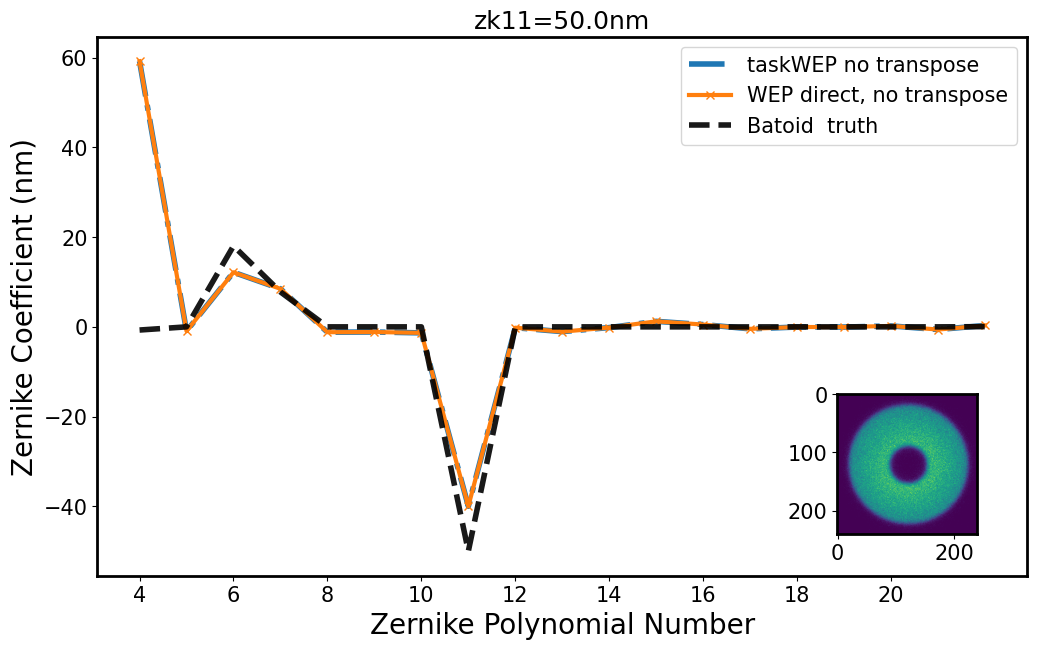

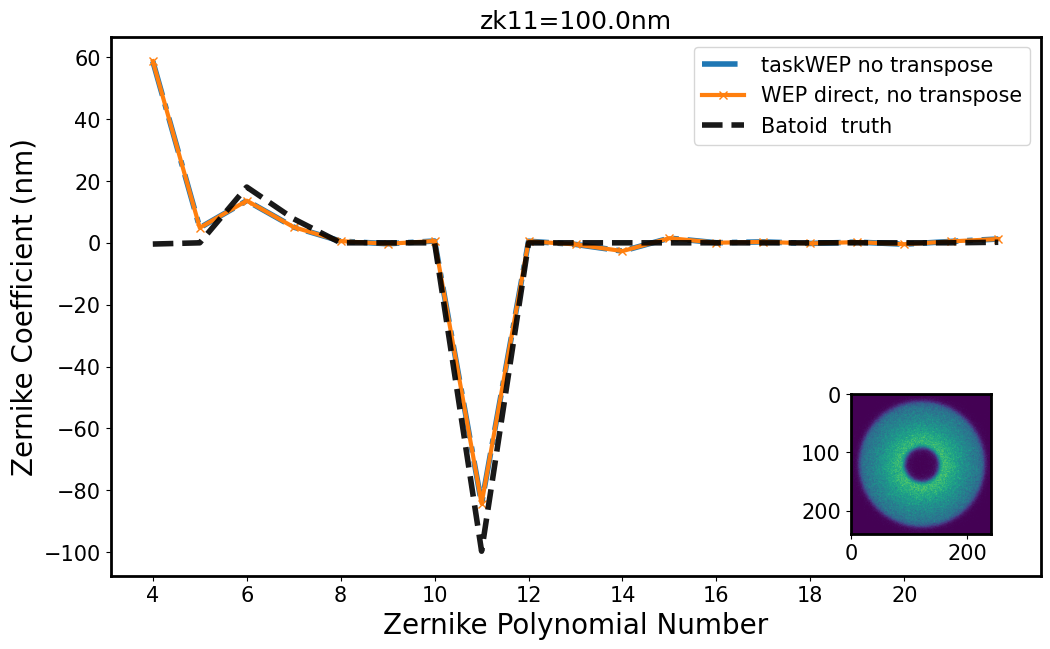

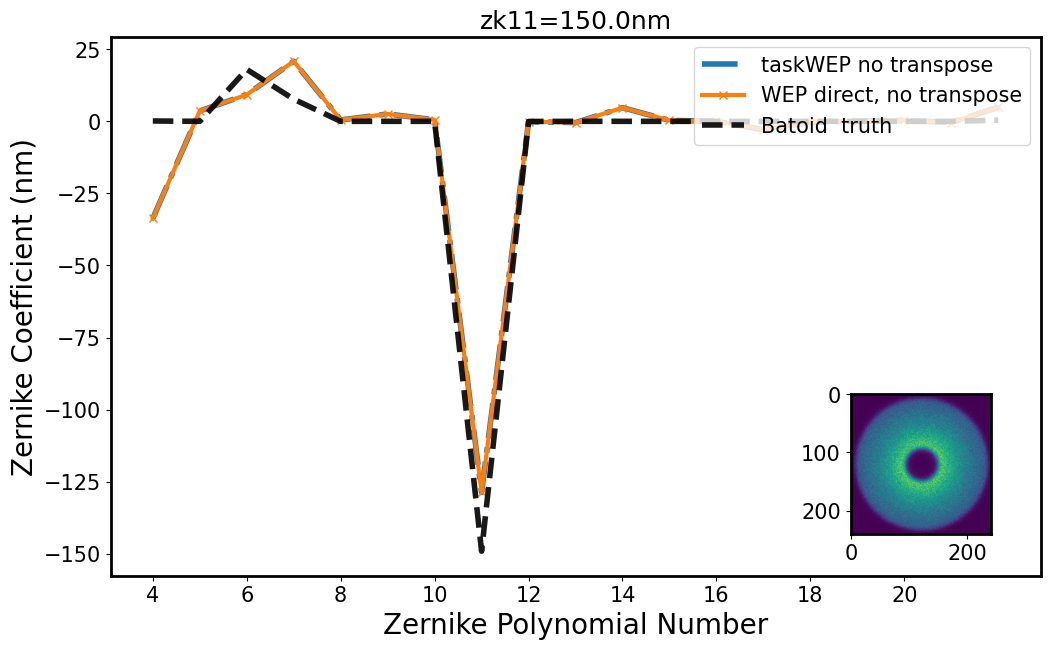

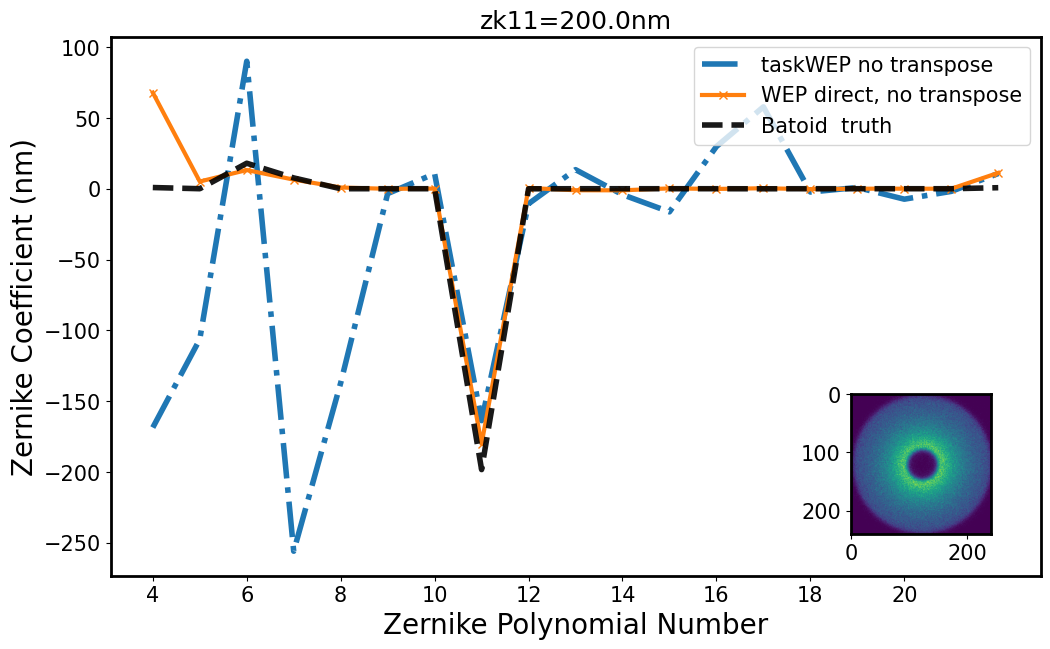

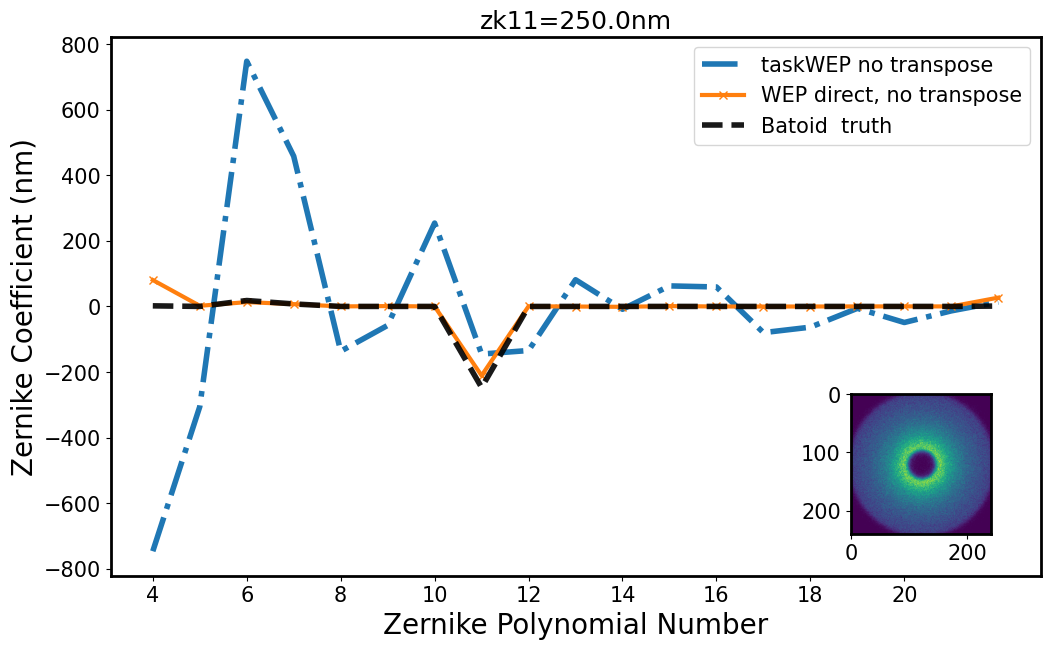

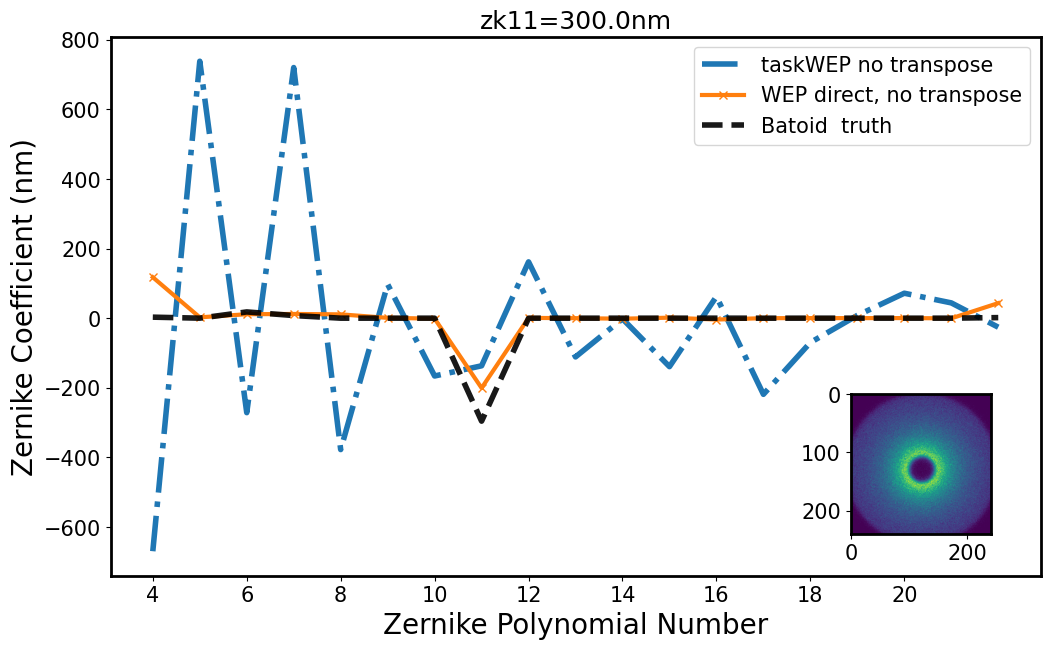

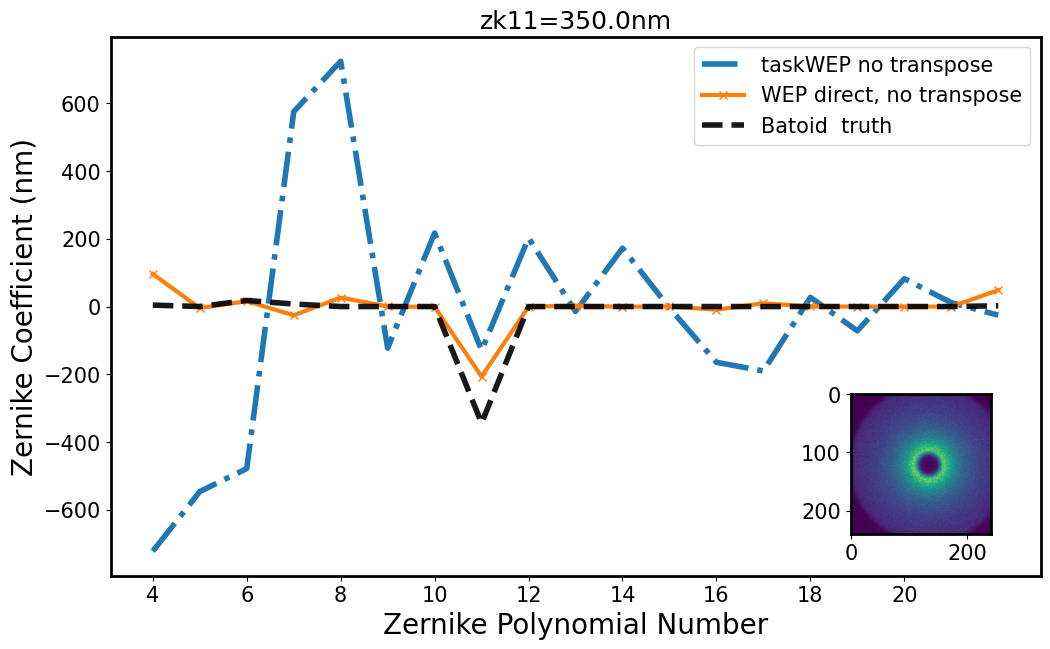

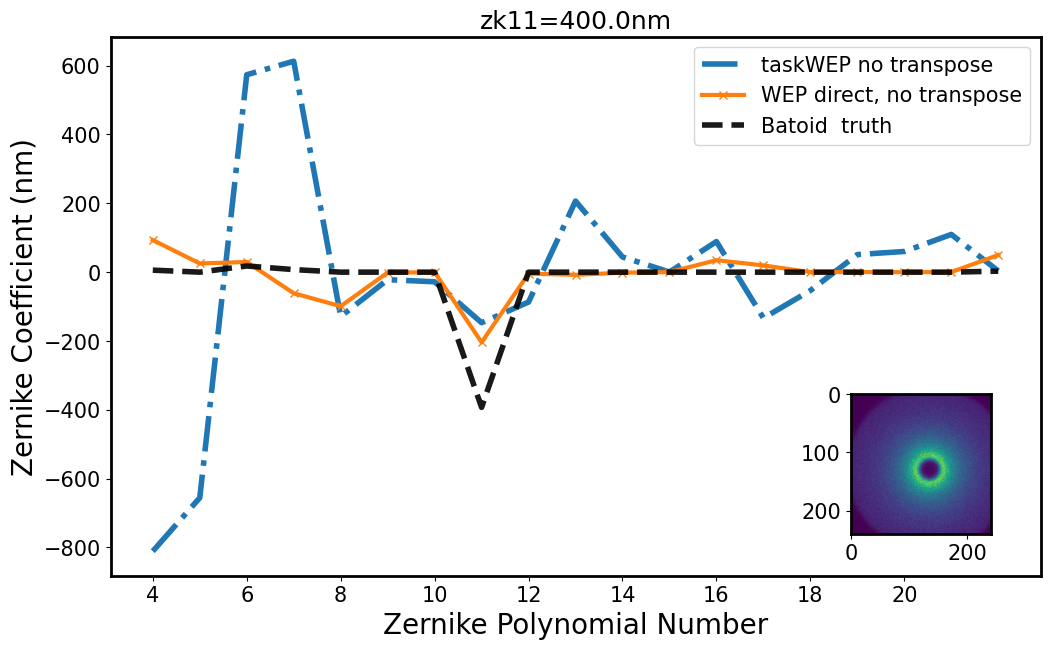

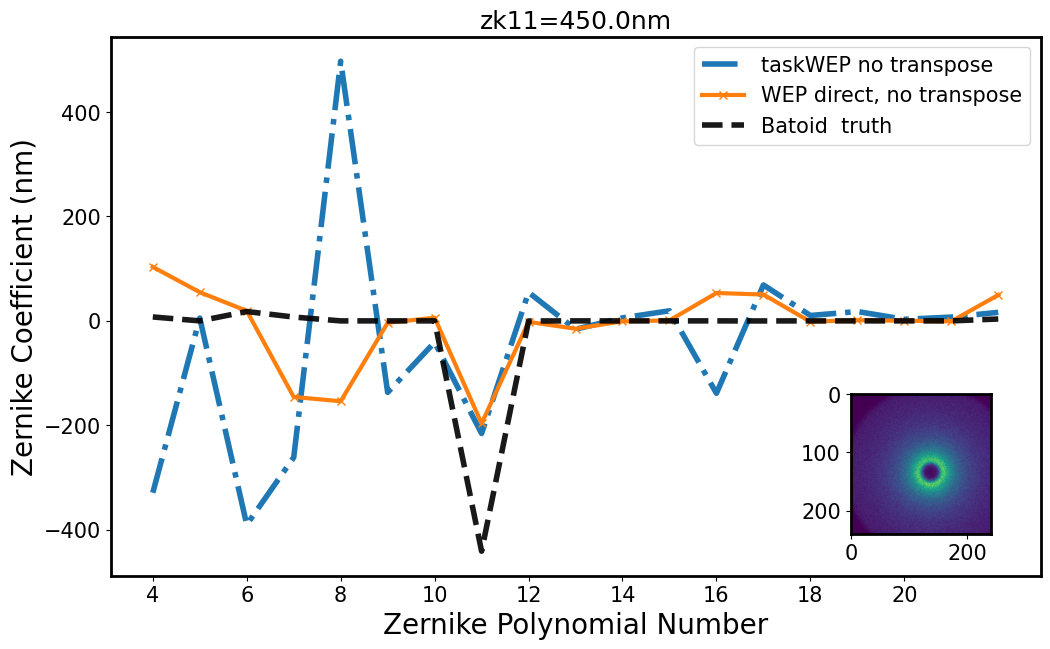

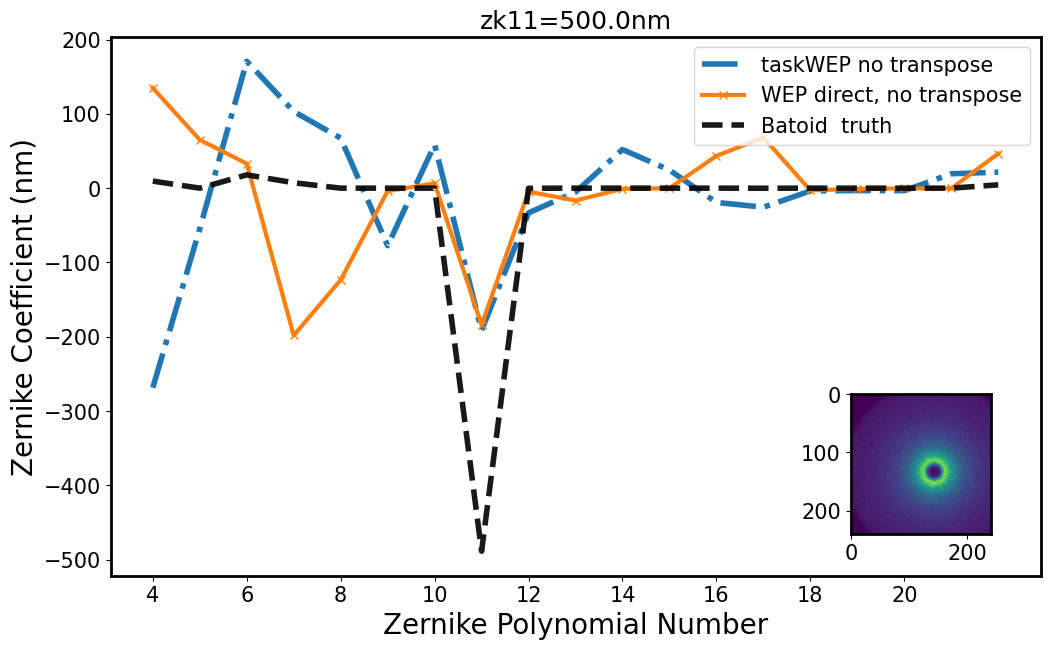

In [42]:
fpath = os.path.join('DM-37629',f'auxtel_batoid_zk11_result_wep_no_transpose.npz')
file = np.load(fpath,allow_pickle=True)
results = file['results'].item()

# fpath = os.path.join('DM-37533',f'auxtel_b_seed{seed}_result_wep_with_transpose.npz')
# file = np.load(fpath,allow_pickle=True)
# resultsT =  file['results'].item()

fpath = os.path.join('DM-37629',f'auxtel_batoid_zk11_result_wep_cwfs_direct.npz')
file = np.load(fpath,allow_pickle=True)
resultsD = file['directresults'].item()

for f in np.linspace(50,500,10):
#i=5
    fig = plt.figure(figsize=(12,7))
    plt.plot(np.arange(4,23), results[f]['zernOutAvg']*1e3, '-.', lw=4, 
             label='taskWEP no transpose') # in microns
#     plt.plot(np.arange(4,23), resultsT[i]['zernOutAvg']*1e3, '-x', lw=3, 
#              label='taskWEP with transpose') # in microns

    plt.plot(np.arange(4,23), resultsD[f]['wepZk'], '-x', lw=3, 
             label='WEP direct, no transpose')
    # plt.plot(np.arange(4,23), resultsD[i]['cwfsZk'], '-x', lw=3, 
    #          label='CWFS direct, no transpose')


#     plt.plot(np.arange(4,23), resultsD[i]['wepZkSwap'], '-x', lw=3, 
#              label='WEP direct, no transpose, swap intra/extra')
    
    # plt.plot(np.arange(4,23), resultsD[i]['cwfsZkSwap'], '-x', lw=3, 
    #          label='CWFS direct, no transpose, swap intra/extra')


    plt.plot(np.arange(4,23), results[f]['truth'][4:]*1e9, ls='--',lw=4,c='k', alpha=0.9, 
             label='Batoid  truth') # in meters

    plt.legend(loc='upper right')
    plt.xlabel('Zernike Polynomial Number')
    plt.ylabel('Zernike Coefficient (nm)')
    plt.title(f'zk11={f}nm')
    plt.xticks(range(4,22)[::2])

    ax = fig.add_axes([0.7,0.17,0.2,0.2])
    ax.imshow(results[f]['donut_intra'][0].stamp_im.image.array)

ok I think I see what's going on : the more zk11, the bigger the donut. So the donut cutout becomes too small! 